In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from glasses.utils.PretrainedWeightsProvider import PretrainedWeightsProvider
from glasses.models import AutoModel
from torch import nn

class Dummy(nn.Sequential):
    def __init__(self):
        super().__init__(nn.Conv2d(3, 32, kernel_size=3), 
                        nn.Conv2d(32, 64, kernel_size=3))

dummy = Dummy()
        
provider = PretrainedWeightsProvider()
# state_dict = provider['dummy']


In [104]:
prev_state_dict = dummy.state_dict()

In [2]:
%matplotlib notebook

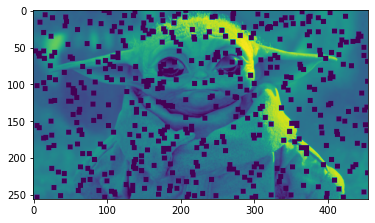

In [22]:
import requests 
import io
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from glasses.nn.regularization import DropBlock
import matplotlib.pyplot as plt
res = requests.get('https://images.everyeye.it/img-notizie/the-mandalorian-baby-yoda-vittima-leak-stuntman-spoilerato-fa-v6-483983-1280x720.jpg')
img = Image.open(io.BytesIO(res.content))
x = Compose([Resize(256), ToTensor()])(img)
# x = torch.ones((1, 3, 56, 56))

out = DropBlock(p=0.2)(x)

fig = plt.figure()
plt.imshow(out.squeeze()[1])
plt.show()

In [75]:
from torch import nn
import torch.nn.functional as F

class RadixSoftmax(nn.Module):
    def __init__(self, radix, cardinality):
        super(RadixSoftmax, self).__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        print(f'4) {x.shape}')
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            print(f'5) {x.shape}')
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
            print(f'6) {x.shape}')
        else:
            x = torch.sigmoid(x)
        return x


class SplitAttnConv2d(nn.Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=False, radix=2, reduction_factor=4,
                 act_layer=nn.ReLU, norm_layer=nn.BatchNorm2d, drop_block=None, **kwargs):
        super(SplitAttnConv2d, self).__init__()
        self.radix = radix
        self.drop_block = drop_block
        mid_chs = out_channels * radix
        print(mid_chs)
        attn_chs = max(in_channels * radix // reduction_factor, 32)

        self.conv = nn.Conv2d(
            in_channels, mid_chs, kernel_size, stride, padding, dilation,
            groups=groups * radix, bias=bias, **kwargs)
        self.bn0 = norm_layer(mid_chs) if norm_layer is not None else None
        self.act0 = act_layer(inplace=True)
        self.fc1 = nn.Conv2d(out_channels, attn_chs, 1, groups=groups)
        self.bn1 = norm_layer(attn_chs) if norm_layer is not None else None
        self.act1 = act_layer(inplace=True)
        self.fc2 = nn.Conv2d(attn_chs, mid_chs, 1, groups=groups)
        self.rsoftmax = RadixSoftmax(radix, groups)

    @property
    def in_channels(self):
        return self.conv.in_channels

    @property
    def out_channels(self):
        return self.fc1.out_channels

    def forward(self, x):
        x = self.conv(x)
        if self.bn0 is not None:
            x = self.bn0(x)
        if self.drop_block is not None:
            x = self.drop_block(x)
        x = self.act0(x)

        B, RC, H, W = x.shape
        print(f'0) {x.shape}')
        if self.radix > 1:
            x = x.reshape((B, self.radix, RC // self.radix, H, W))
            print(f'1) {x.shape}')
            x_gap = x.sum(dim=1)
            print(f'2) {x_gap.shape}')
        else:
            x_gap = x
        x_gap = F.adaptive_avg_pool2d(x_gap, 1)
        print(f'3) {x_gap.shape}')

        x_gap = self.fc1(x_gap)
        if self.bn1 is not None:
            x_gap = self.bn1(x_gap)
        x_gap = self.act1(x_gap)
        x_attn = self.fc2(x_gap)

        x_attn = self.rsoftmax(x_attn).view(B, -1, 1, 1)
        print(f'x_attn: {x_attn.shape}')
        if self.radix > 1:
            x_attn = x_attn.reshape((B, self.radix, RC // self.radix, 1, 1))
            print(f'7){x_attn.shape}')
            print(f'x){x.shape}')
            out = (x * x_attn).sum(dim=1)
        else:
            out = x * x_attn
        return out.contiguous()

In [86]:
AutoModelx = torch.randn((3, 64, 28, 28))

split  = SplitAttnConv2d(64, 64, kernel_size=3, padding=1)
print(split)
split(x).shape

128
SplitAttnConv2d(
  (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
  (bn0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act0): ReLU(inplace=True)
  (fc1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (fc2): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
  (rsoftmax): RadixSoftmax()
)
0) torch.Size([3, 128, 28, 28])
1) torch.Size([3, 2, 64, 28, 28])
2) torch.Size([3, 64, 28, 28])
3) torch.Size([3, 64, 1, 1])
4) torch.Size([3, 128, 1, 1])
5) torch.Size([3, 2, 1, 64])
6) torch.Size([3, 128])
x_attn: torch.Size([3, 128, 1, 1])
7)torch.Size([3, 2, 64, 1, 1])
x)torch.Size([3, 2, 64, 28, 28])


torch.Size([3, 64, 28, 28])

In [111]:
from glasses.models.classification.resnest import SplitAtt, ResNeStBottleneckBlock

In [115]:
ResNeStBottleneckBlock(64, 64, radix=2, groups=1, base_width=64)

ResNeStBottleneckBlock(
  (block): Sequential(
    (0): ConvBnDropAct(
      (conv): Conv2dPad(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (reg): DropBlock(p=0)
      (act): ReLU(inplace=True)
    )
    (1): Identity()
    (2): ConvBnDropAct(
      (conv): Conv2dPad(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2, bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (reg): DropBlock(p=0)
      (act): ReLU(inplace=True)
    )
    (3): SplitAtt(
      (att): Sequential(
        (0): Reduce('b r (k c) h w-> b (k c) h w', 'sum', r=2, k=1)
        (1): AdaptiveAvgPool2d(output_size=1)
        (2): ConvBnAct(
          (conv): Conv2dPad(16, 32, kernel_size=(1, 1), stride=(1, 1))
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU(inplace=True)


In [110]:
x = torch.randn((3, 128, 28, 28))
att = SplitAtt(64, features=32, radix=2, groups=1)
print(att)
att(x).shape

SplitAtt(
  (att): Sequential(
    (0): Reduce('b r (k c) h w-> b (k c) h w', 'sum', r=2, k=1)
    (1): AdaptiveAvgPool2d(output_size=1)
    (2): ConvBnAct(
      (conv): Conv2dPad(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace=True)
    )
    (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (4): Rearrange('b (r k c) h w -> b r k c h w', r=2, k=1)
    (5): Softmax(dim=1)
    (6): Rearrange('b r k c h w -> b r (k c) h w', r=2, k=1)
  )
)


torch.Size([3, 64, 28, 28])

In [17]:
from torchsummary import summary
import timm
model = timm.create_model('resnest26d')

summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
        MaxPool2d-10           [-1, 64, 56, 56]               0
           Conv2d-11           [-1, 64, 56, 56]           4,096
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [55]:
timm.list_models('resnest*')

['resnest14d',
 'resnest26d',
 'resnest50d',
 'resnest50d_1s4x24d',
 'resnest50d_4s2x40d',
 'resnest101e',
 'resnest200e',
 'resnest269e']

In [53]:
model = ResNetSt.resnest14d().eval()
model.encoder.features
model(torch.randn((1,3,224,224)))
features = model.encoder.features
print([x.shape for x in features])

[torch.Size([1, 64, 112, 112]), torch.Size([1, 256, 56, 56]), torch.Size([1, 512, 28, 28]), torch.Size([1, 1024, 14, 14])]


# Benchmark

In [2]:
from glasses.models import AutoModel, AutoConfig
import torch

In [37]:
model = AutoModel.from_name('vit_base_patch16_224')
model

ViT(
  (embedding): PatchEmbedding(
    (projection): Sequential(
      (0): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (1): Rearrange('b e (h) (w) -> b (h w) e')
    )
    (tokens): ViTTokens()
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderBlock(
        (0): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): MultiHeadAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (att_drop): Dropout(p=0.0, inplace=False)
              (projection): Sequential(
                (0): Linear(in_features=768, out_features=768, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
        )
        (1): ResidualAdd(
          (fn): Sequential(
            (0): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (1): FeedForwardBlock(
              (0): 

In [54]:
from glasses.models.classification.deit import DeiT
DeiT().embedding.tokens.dist_token

Parameter containing:
tensor([[[ 1.8139e+00,  4.3294e-01, -1.0594e+00,  1.2178e+00, -5.1684e-01,
          -5.7020e-01, -1.6492e+00,  5.9889e-01, -1.4083e+00, -1.7492e+00,
           1.4628e+00,  2.0315e+00,  3.5535e-02, -1.5276e+00, -3.4329e-01,
          -9.6625e-01,  1.4201e+00, -2.9760e-01, -1.1336e+00,  6.0696e-01,
           2.8885e-01,  5.0535e-02,  1.6611e+00, -2.4462e-01,  1.3862e+00,
          -8.6118e-01,  4.1896e-01,  1.0207e+00, -4.9626e-01,  1.4439e+00,
           3.5824e-01, -7.6022e-01,  9.1688e-02, -1.4409e+00, -6.7320e-01,
          -3.2345e-01, -3.0303e-01, -1.9116e-01,  1.6442e-01, -9.5486e-01,
          -2.4387e-01, -3.6958e-01, -1.4860e+00, -5.9129e-01, -7.7090e-01,
           6.2197e-01,  1.2709e+00,  3.5272e-01, -1.2842e+00, -4.1972e-01,
           2.7664e-01,  1.0724e+00,  7.4461e-01,  1.2605e+00,  1.4620e+00,
          -1.8566e+00,  1.3715e+00,  6.6508e-01,  8.6190e-01,  1.2123e+00,
          -5.7741e-01,  4.9280e-01, -7.3030e-03, -1.4707e+00, -3.5965e-01,
   

In [10]:
import torch
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_distilled_patch16_224', pretrained=True)

Using cache found in /home/zuppif/.cache/torch/hub/facebookresearch_deit_main
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_distilled_patch16_224-df68dfff.pth" to /home/zuppif/.cache/torch/hub/checkpoints/deit_base_distilled_patch16_224-df68dfff.pth


In [11]:
model

DistilledVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(


In [47]:
ViT()(torch.randn((2,3,224,224)))

torch.Size([2, 197, 768])


tensor([[-0.0454, -0.5833,  0.2980,  ..., -0.5219, -0.5729, -0.6744],
        [-0.0938, -0.6276,  0.3209,  ..., -0.5340, -0.5642, -0.7091]],
       grad_fn=<AddmmBackward>)

In [ ]:
class MyTokens

In [14]:
import torch
model(torch.randn((2,3,224,224)))

[torch.Size([2, 1, 768])]


tensor([[ 0.0454, -0.0183,  0.6613,  ..., -0.3889,  0.4319,  0.7054],
        [ 0.0427, -0.0224,  0.6951,  ..., -0.4088,  0.4498,  0.6888]],
       grad_fn=<AddmmBackward>)

In [ ]:
type(AutoModel.models())

In [ ]:
cfg = AutoConfig.from_name('resnet18')
cfg.transform

In [ ]:
from glasses.utils.PretrainedWeightsProvider import PretrainedWeightsProvider

In [ ]:
PretrainedWeightsProvider.BASE_DIR

# Clone

In [10]:
import torch
from glasses.models import AutoModel, AutoConfig, EfficientNetLite
import timm
from transfer_weights import clone_model
from benchmark import benchmark
from glasses.models.classification.vit import ViTTokens

src = timm.create_model('vit_base_patch16_224', pretrained='True')
dst = AutoModel.from_name('vit_base_patch16_224')
transform = AutoConfig.from_name('vit_base_patch16_224').transform

dst = clone_model(src, dst, torch.randn((1, 3, 224, 224)), dest_skip = [ViTTokens]).eval()

[autoreload of glasses.utils.ModuleTransfer failed: Traceback (most recent call last):
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/zuppif/anaconda3/envs/dl/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 266,

TypeError: argument of type 'NoneType' is not iterable

In [98]:
benchmark(src.cuda().eval(), transform, batch_size=128, fast=True)

Using downloaded and verified file: ./imagenet_val_targets.pkl


(None, None, None)

In [109]:
dst.embedding.positions.data.copy_(src.pos_embed.data.squeeze(0))
dst.embedding.tokens.cls.data.copy_(src.cls_token.data)
benchmark(dst.cuda().eval(), transform, batch_size=128, fast=True)

Using downloaded and verified file: ./imagenet_val_targets.pkl


(None, None, None)

In [ ]:
summary(timm.create_model('vit_base_patch16_224', pretrained=True), (3, 224, 224), device='cpu')

In [ ]:
dst.embedding.positions.data.copy_(src.pos_embed.data.squeeze(0))
dst.embedding.cls_token.data.copy_(src.cls_token.data)

transform = AutoConfig.from_name('vit_base_patch16_384').transform

benchmark(dst.cuda().eval(), transform, batch_size=128)

In [ ]:
from torchsummary import summary
from glasses.models.classification.vit import ViT

summary(VisionTransformer(), (3, 224, 224), device='cpu')

In [15]:
dst.training

False

# Pretrained weights

In [ ]:
from pathlib import Path

root = Path('/home/zuppif/Documents/glasses-weights/')

models = map(lambda x: x.stem, root.glob('*.pth'))

for model in models:
    print(f"'{model}': BasicUrlHandler('https://github.com/FrancescoSaverioZuppichini/glasses-weights/blob/main/{model}.pth?raw=true'),")

## Traced

In [ ]:
from glasses.utils.Tracker import Tracker
import torch

def trace(model, x):
    return Tracker(model)(x)

In [ ]:
x = torch.randn((1, 3, 224, 224))

trace(ViT(), x)

In [ ]:
x = torch.randn((1, 3, 224, 224))

trace(timm.create_model('vit_base_patch16_224', pretrained=True), x).traced

In [ ]:
trace(timm.create_model('vit_base_patch16_224', pretrained=True), x).parametrized

In [ ]:
ViT()

In [ ]:
timm.create_model('vit_base_patch16_224', pretrained=True)